<a href="https://colab.research.google.com/github/VinayakSNayak/PriorityModel_BBMP/blob/main/BBMP_Complaint_Prioritization_(Dynamic_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Stage 1: Problem Definition ---
Problem: BBMP needs to prioritize thousands of citizen complaints to allocate resources efficiently.
Goal: Build an ML model to predict the priority (High, Medium, Low) of a complaint.
--------------------------------------------------
--- Stage 2: Load Dataset ---
Successfully loaded '2025-grievances.csv'.
Dataset has 126974 records and 8 features.
--------------------------------------------------
--- Stage 3: Data Preprocessing & Feature Engineering ---
Data shape after dropping missing values: (126920, 8)
Data preprocessing complete.
--------------------------------------------------
--- Stage 6 (Part 1): Visualizing Data ---


/tmp/ipython-input-487781480.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Priority', order=['Low', 'Medium', 'High'], palette='viridis')


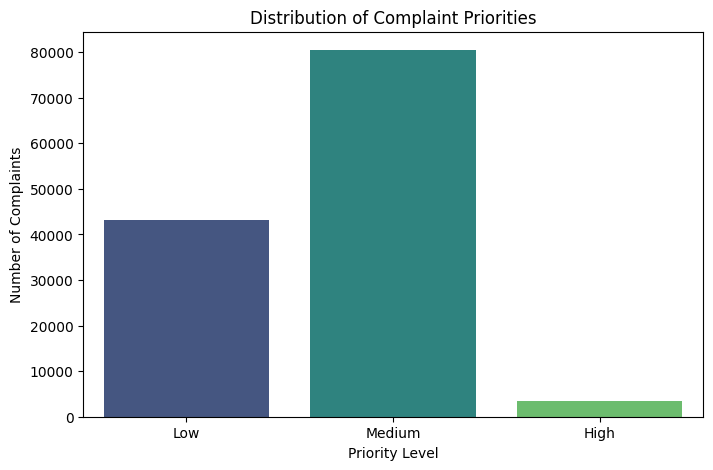

/tmp/ipython-input-487781480.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_wards.values, y=top_10_wards.index, palette='mako')


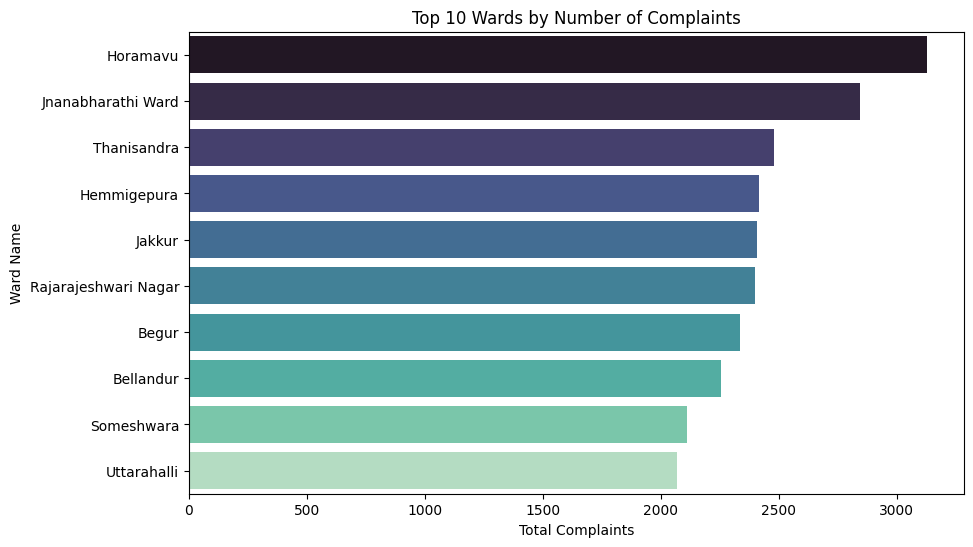

--- Stage 4: Training ML Models ---
Training set size: 101536
Test set size: 25384

Training Model 1: Logistic Regression...
Logistic Regression training complete.

Training Model 2: Random Forest...
Random Forest training complete.
--------------------------------------------------
--- Stage 5: Evaluating Models ---

--- Model 1: Logistic Regression Evaluation ---
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       679
         Low       1.00      1.00      1.00      8614
      Medium       1.00      1.00      1.00     16091

    accuracy                           1.00     25384
   macro avg       1.00      1.00      1.00     25384
weighted avg       1.00      1.00      1.00     25384


--- Model 2: Random Forest Evaluation ---
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       679
         Low       1.00      1.00      1.00      8614
      Medium       1.00      1.00      1.00  

/tmp/ipython-input-487781480.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_comparison_df, x='Model', y='Accuracy', palette='cool')


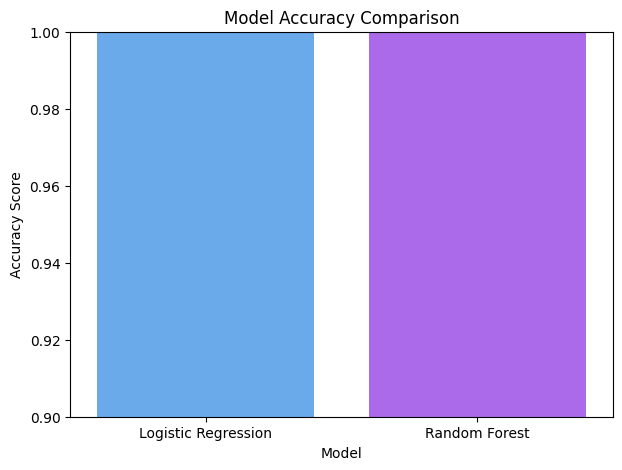

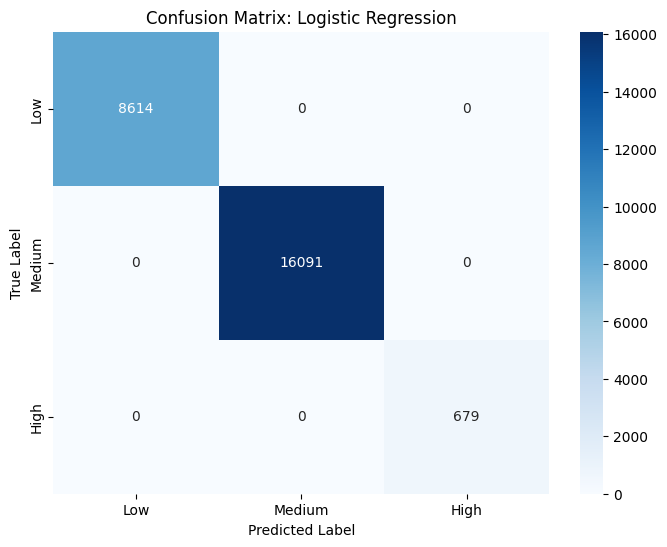

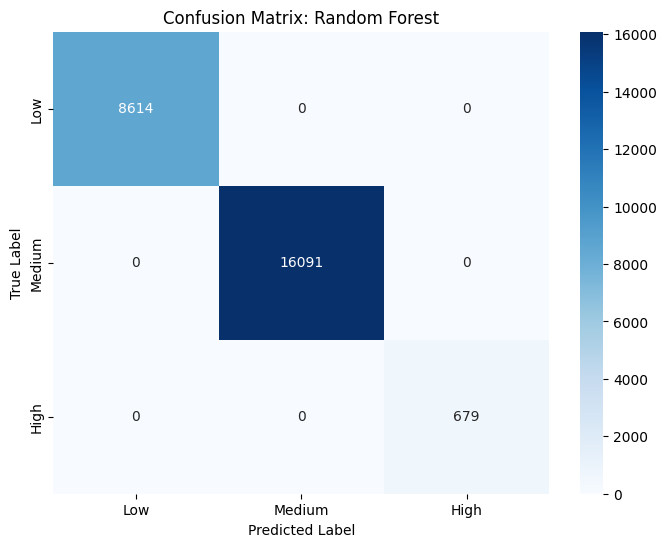


Project Stages 1-6 Complete.
--------------------------------------------------
--- Final Step: Creating Prioritized Work List (using best model) ---
Found 10257 pending complaints to prioritize.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


-------------------------------------------------
✅ Project Complete!
A prioritized work list has been saved to: 'bbmp_priority_worklist.csv'

Top 10 Most Urgent Complaints to Address:
       Complaint ID  Priority_Score                   Complaint_Text Ward Name
27207      20744464             1.0      Lakes Sewage inflow to lake  Horamavu
6440       20765250             1.0  Road Maintenance(Engg) Potholes  Horamavu
15498      20756176             1.0  Road Maintenance(Engg) Potholes  Horamavu
27761      20743910             1.0      Lakes Sewage inflow to lake  Horamavu
2800       20768890             1.0  Road Maintenance(Engg) Potholes  Horamavu
16051      20755623             1.0  Road Maintenance(Engg) Potholes  Horamavu
8066       20763624             1.0  Road Maintenance(Engg) Potholes  Horamavu
27520      20744151             1.0      Lakes Sewage inflow to lake  Horamavu
36178      20735486             1.0      Lakes Sewage inflow to lake  Horamavu
10055      20761620     

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Import ML Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Import Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Stage 1: Define the Problem and Prediction Goal ---
print("--- Stage 1: Problem Definition ---")
print("Problem: BBMP needs to prioritize thousands of citizen complaints to allocate resources efficiently.")
print("Goal: Build an ML model to predict the priority (High, Medium, Low) of a complaint.")
print("-" * 50)


# --- Stage 2: Collect and Load Dataset ---
print("--- Stage 2: Load Dataset ---")
# Download NLTK stopwords
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Load dataset
FILE_NAME = '2025-grievances.csv'
try:
    df = pd.read_csv(FILE_NAME, on_bad_lines='skip')
    print(f"Successfully loaded '{FILE_NAME}'.")
    print(f"Dataset has {df.shape[0]} records and {df.shape[1]} features.")
except FileNotFoundError:
    print(f"Error: Could not find the file '{FILE_NAME}'.")
    exit()
print("-" * 50)


# --- Stage 3: Preprocess Data ---
print("--- Stage 3: Data Preprocessing & Feature Engineering ---")

# a) Handle missing values
df = df.dropna(subset=['Category', 'Sub Category', 'Ward Name', 'Grievance Status'])
print(f"Data shape after dropping missing values: {df.shape}")

# b) Feature Engineering: Create 'Complaint_Text'
df['Complaint_Text'] = df['Category'] + ' ' + df['Sub Category']

# c) Feature Engineering: Create 'Num_Prev_Complaints' for area analysis
ward_counts = df['Ward Name'].value_counts()
df['Num_Prev_Complaints'] = df['Ward Name'].map(ward_counts)

# d) Label Creation: Encode categorical 'Priority'
def assign_priority(text):
    text_low = str(text).lower()
    if any(k in text_low for k in ['pothole', 'sewage', 'water leakage']):
        return 'High'
    if any(k in text_low for k in ['garbage', 'streetlight', 'electrical']):
        return 'Medium'
    return 'Low'

df['Priority'] = df['Complaint_Text'].apply(assign_priority)

# e) Text Preprocessing Function
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = text.lower()
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

print("Data preprocessing complete.")
print("-" * 50)


# --- Stage 6 (Part 1): Exploratory Data Visualization ---
print("--- Stage 6 (Part 1): Visualizing Data ---")
# (Visualizations will be generated and shown in the Colab/Jupyter output)

# 1. Visualize Priority Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Priority', order=['Low', 'Medium', 'High'], palette='viridis')
plt.title('Distribution of Complaint Priorities')
plt.xlabel('Priority Level')
plt.ylabel('Number of Complaints')
plt.show()

# 2. Visualize Top 10 Wards by Complaint Volume
plt.figure(figsize=(10, 6))
top_10_wards = ward_counts.head(10)
sns.barplot(x=top_10_wards.values, y=top_10_wards.index, palette='mako')
plt.title('Top 10 Wards by Number of Complaints')
plt.xlabel('Total Complaints')
plt.ylabel('Ward Name')
plt.show()


# --- Stage 4: Apply ML Algorithms ---
print("--- Stage 4: Training ML Models ---")

# a) Define features (X) and target (y)
X = df['Complaint_Text']
y = df['Priority']

# b) Create Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# --- Model 1: Logistic Regression ---
print("\nTraining Model 1: Logistic Regression...")
log_reg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=clean_text, max_features=5000)),
    ('clf', LogisticRegression(random_state=42, class_weight='balanced'))
])
log_reg_pipeline.fit(X_train, y_train)
print("Logistic Regression training complete.")

# --- Model 2: Random Forest ---
print("\nTraining Model 2: Random Forest...")
rand_forest_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=clean_text, max_features=5000)),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100))
])
rand_forest_pipeline.fit(X_train, y_train)
print("Random Forest training complete.")
print("-" * 50)


# --- Stage 5: Evaluate Model Performance ---
print("--- Stage 5: Evaluating Models ---")

# a) Get predictions
y_pred_lr = log_reg_pipeline.predict(X_test)
y_pred_rf = rand_forest_pipeline.predict(X_test)

# b) Get full classification reports
print("\n--- Model 1: Logistic Regression Evaluation ---")
print(classification_report(y_test, y_pred_lr))

print("\n--- Model 2: Random Forest Evaluation ---")
print(classification_report(y_test, y_pred_rf))

# c) (NEW) Compare accuracy scores and select the best model
lr_accuracy = accuracy_score(y_test, y_pred_lr)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"\nModel Accuracy Scores:")
print(f"  - Logistic Regression: {lr_accuracy:.4f}")
print(f"  - Random Forest: {rf_accuracy:.4f}")

if lr_accuracy > rf_accuracy:
    best_model_pipeline = log_reg_pipeline
    print("\n--- (NEW) Winner: Logistic Regression was selected. ---")
else:
    best_model_pipeline = rand_forest_pipeline
    print("\n--- (NEW) Winner: Random Forest was selected (or tied). ---")

print("-" * 50)


# --- Stage 6 (Part 2): Visualize Results ---
print("--- Stage 6 (Part 2): Visualizing Results ---")

# 1. Visualize Model Comparison
model_scores = {
    'Logistic Regression': lr_accuracy,
    'Random Forest': rf_accuracy
}
model_comparison_df = pd.DataFrame(model_scores.items(), columns=['Model', 'Accuracy'])
plt.figure(figsize=(7, 5))
sns.barplot(data=model_comparison_df, x='Model', y='Accuracy', palette='cool')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy Score')
plt.ylim(0.9, 1.0) # Set ylim for a clearer view if scores are high
plt.show()

# 2. Visualize Confusion Matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['Low', 'Medium', 'High'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(y_test, y_pred_lr, 'Confusion Matrix: Logistic Regression')
plot_confusion_matrix(y_test, y_pred_rf, 'Confusion Matrix: Random Forest')

print("\nProject Stages 1-6 Complete.")
print("-" * 50)


# --- BONUS: Solving the Real-World Problem (USING THE BEST MODEL) ---

print("--- Final Step: Creating Prioritized Work List (using best model) ---")

# 1. (NEW) Get class indices from the *best* model
model_classes = list(best_model_pipeline.classes_)
high_idx = model_classes.index('High')
medium_idx = model_classes.index('Medium')

# 2. (NEW) Calculate Text_Score for ALL complaints using the *best* model
all_text_probs = best_model_pipeline.predict_proba(df['Complaint_Text'])
df['Text_Score'] = all_text_probs[:, high_idx] * 1.0 + all_text_probs[:, medium_idx] * 0.5

# 3. Normalize Area_Score
area_scaler = MinMaxScaler()
df['Area_Score'] = area_scaler.fit_transform(df[['Num_Prev_Complaints']])

# 4. Calculate final Priority_Score
alpha = 0.7
beta = 0.3
df['Priority_Score'] = (alpha * df['Text_Score']) + (beta * df['Area_Score'])

# 5. Filter for "Registered" (unsolved) complaints
pending_complaints_df = df[df['Grievance Status'] == 'Registered'].copy()
print(f"Found {len(pending_complaints_df)} pending complaints to prioritize.")

# 6. Sort by the final score to get the worklist
priority_worklist_df = pending_complaints_df.sort_values(by='Priority_Score', ascending=False)

# 7. Save the final list
WORKLIST_FILE = 'bbmp_priority_worklist.csv'
priority_worklist_df.to_csv(WORKLIST_FILE, index=False)

# Add code to automatically download the file
from google.colab import files
files.download(WORKLIST_FILE)

print("\n-------------------------------------------------")
print("✅ Project Complete!")
print(f"A prioritized work list has been saved to: '{WORKLIST_FILE}'")
print("\nTop 10 Most Urgent Complaints to Address:")
print(priority_worklist_df[['Complaint ID', 'Priority_Score', 'Complaint_Text', 'Ward Name']].head(10))
print("-------------------------------------------------")